In [1]:
#import modules
#%pylab inline 
#matplotlib notebook 
import os 
import nglview as nv
import numpy as np
#import mdtraj as mdt
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from matplotlib import rc
plt.rc('text', usetex=True)
import seaborn as sns
#plt.rc('font', family='serif')
import collections
from scipy.ndimage.filters import gaussian_filter
import pandas as pd

_ColormakerRegistry()

In [2]:
from scipy.signal import argrelextrema

In [3]:
plt.style.use('seaborn-poster')
sns.set_context("poster")
#print(plt.style.available)

In [4]:
Sim_Direc = !(ls -l | grep '^d'| awk '{print $9}')
bas_dir = !pwd
#Sim_Direc = !(ls -d */)

In [5]:
print(bas_dir[0])
print(Sim_Direc)
#colors taken from https://matplotlib.org/3.1.0/gallery/color/named_colors.html
col=['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
      'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

/media/john/ARCHIVOS/Trabajo_de_grado/SIMS_ALL_FEB/mdstress_github/mdstress_github
['15STX-DMPG', '15STX-DPPG', '15STXrigid-DMPG', '15STXrigid-DPPG', 'MEM-DMPG', 'MEM-DPPG', 'STX-DMPG', 'STX-DPPG', 'STXrigid-DMPG', 'STXrigid-DPPG']


## Read & Sorting function:
It puts arranges in regular intervals, like 0.0, 1.1,.... If some two values are in the same interval, it averages these values and if there isn't a value in an interval it puts 0 value.

In [6]:
def sort(file,direc,sk_l1,sk_l2,dt):#=0.05):
#input of directories
    if("MEM" in direc):
        start=1;
        N=1
    else:
        start=1;
        N=5
    n=[]; m=[];
    t=np.zeros((N,8000)); x=np.zeros((N,8000,8000));
    pos_zeros=[]
    pos_zeros2=[[],[],[],[],[]]
    for replica in range(start,N+1):
        work_dir = ("{}/{}".format(direc,replica))
        data = np.genfromtxt("{}/{}/{}".format(bas_dir[0],work_dir,file),skip_header=sk_l1)
###############################
        n0=np.shape(data[:,1:])[0]
        m0=np.shape(data[:,1:])[1]
        m=np.append(m,m0)
        t0=data[0,0]#0.
        pos=0
        temp=0
        xtemp=np.zeros((1,m0))
        t[replica-1,0]=data[0,0]
        x[replica-1,0,:m0]=data[0,1:]
        #print("replica {}".format(replica))
        for i in range(1,n0):
            pos_ant=pos
            pos=int(np.round((data[i,0]-t0)/dt))
            #print(i,"\t",pos_ant,"\t",pos,data[i-1,0])
            if(pos_ant==pos):
                t[replica-1,pos]=(temp+data[i,0])/2
                x[replica-1,pos,:m0]=(xtemp+data[i,1:])/2
                #print(i,"\t",pos_ant,"\t",pos,data[i-1,0])
            else:
                t[replica-1,pos]=data[i,0]
                x[replica-1,pos,:m0]=data[i,1:]
                if(pos_ant+1<pos):
                    #print("k",i,"\t",pos_ant,"\t",pos)
                    #pos_zeros2[replica-1]=np.append(pos_zeros[replica-1],pos)
                    pos_zeros.append(pos-1)
                    pos_zeros2[replica-1].append(pos-1)
            #print(np.round((data[i-1,0]-t0)/dt)," ",data[i-1,0]," ",t[i-1,replica-1]," ",temp)
            #print(pos_ant,"\t",pos,"\t",t[replica-1,i]) #,"\t",data[i-1,1:])
            temp=data[i,0]#dato anterior
            xtemp=data[i,1:]#dato anterior
        n=np.append(n,pos)
        #print("fin replica", end="\n")
    n0=int(np.min(n))+1
    m0=int(np.min(m))+1
    x_f_tmp=[];t_f_tmp=[]; skip=np.array([])
    d = {x:pos_zeros.count(x) for x in pos_zeros}#set of  pos_zeros and its frequencies
    #print(list(d.keys()))
    #print(d.values())
    skip=list(list(d.keys()))#np.array(list(d.keys())).sort()
    skip.sort()
#    print("skipped:",skip)
#     if(len(skip)==0): #It's in the case we don't skip
#         skip.append((n0+1)*np.ones(n0))
    for i in range(n0):
#         if(i<len(skip)):
        cnt=0
        for j in range(len(skip)):
            if(i==skip[j]):#and(t[:,i].any()!=0):
                cnt+=1
        if(cnt==0):
            x_f_tmp.append(x[:,i,:m0])
            t_f_tmp.append(t[:,i]) 
#            print(i,"\t",t[:,i])
#         elif(i>=len(skip)):
#             x_f_tmp.append(x[:,i,:m0])
#             t_f_tmp.append(t[:,i])            
#            #print(np.shape(x[:,i,:m0]),"\t",t[:,i])
    x_final=[];t_final=[];
    for i in range(len(t_f_tmp)):
        t_final.append(list(t_f_tmp[i]))
    t_final=np.array(t_final)
    for i in range(len(x_f_tmp)):
        x_final.append(list(x_f_tmp[i]))
    x_final=np.array(x_final)
    #print(n,m)
    #print(n0,m0)
    #print(pos_zeros)
    print(np.shape(t_final),"\t",np.shape(x_final))
    #print(x_f_tmp)#,"\t",pos_zeros2)
    return t_final, x_final
    #print(t[:,:n0])#,"\t",pos_zeros2)
    #return t[:,:n0],x[:,:n0,:m0]

## Computation of phosphate positions using gromacs density

In [7]:
def phosphate(file,direc,sk_l1):#=0.05):
#         cnt=9
#         sk_l1=0
#         file="density/p_density.xvg"     
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in direc):
                z_com=3.96152
            elif("DPPG" in direc):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7
        z_tmp=[[],[]]
        for replica in range(start,N+1):
            work_dir = ("{}/{}/{}".format(bas_dir[0],direc,replica))
            data = np.genfromtxt("{}/{}".format(work_dir,file),skip_header=sk_l1)
#             print(np.shape(data[:,1]))
            maxInd = argrelextrema(data[:,1], np.greater)
            z_tmp[0].append(data[maxInd,0][0][0])
            z_tmp[1].append(data[maxInd,0][0][1])
#         r = data[maxInd,1]  
#         print(r,maxInd)
#         print(z_tmp[0])
#         print(z_tmp[1])
        return np.average(z_tmp[0]),np.average(z_tmp[1])

# Computation of stress profile along z axis.
* Crystalline, Ordered and Disordered Lipid Membranes: Convergence of Stress Profiles due to Ergosterol Juan M. Vanegas,

In [8]:
def pi(stress):
    pxx=-stress[:,:,0]
    pyy=-stress[:,:,4]
    pzz=-stress[:,:,8]
    return (pxx+pyy)/2-pzz

In [9]:
def pi_s(stress):
    pxx=-stress[:,0]
    pyy=-stress[:,4]
    pzz=-stress[:,8]
    return (pxx+pyy)/2-pzz

In [10]:
def av(x):
    pi_av=[]
    for i in range(len(x[:,0])):
        pi_av=np.append(pi_av,np.average(x[i,:]))
    np.shape(pi_av)
    return pi_av

# Plots

## Z_com of membrane

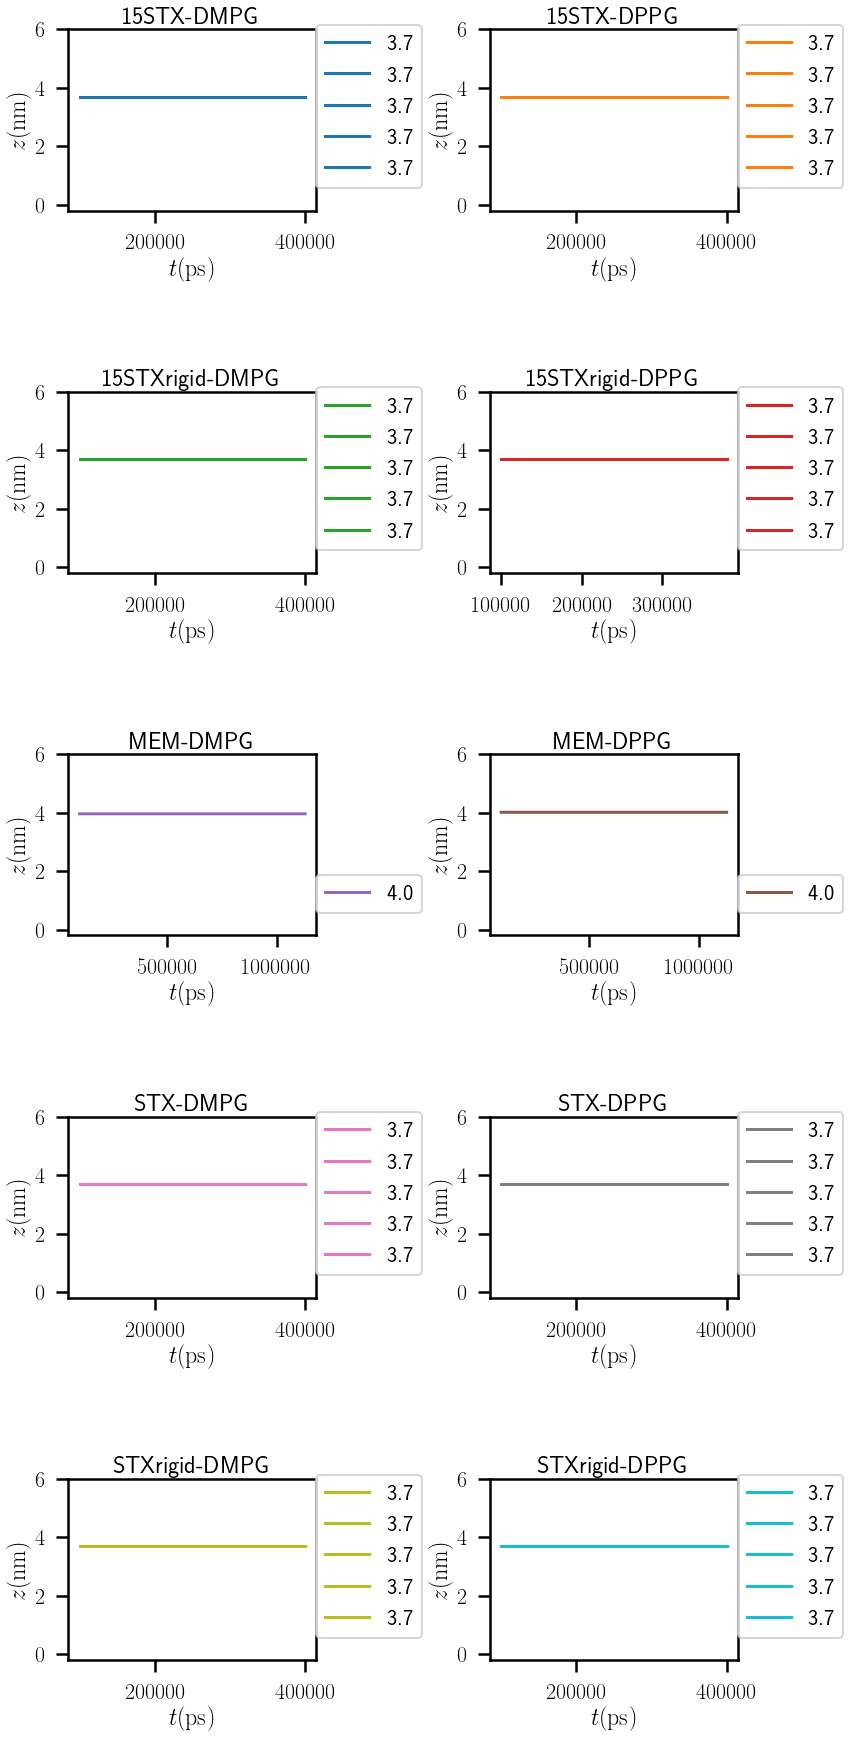

In [11]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=False,figsize=(12,30),gridspec_kw={'hspace': 1, 'wspace': 0.7})
com_memb=[]
for i in range(N):
    for j in range(M):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
        else:
            start=1;
            N=5
        for replica in range(start,N+1):
            work_dir = ("{}/{}".format(Sim_Direc[cnt],replica))
            data = np.genfromtxt("{}/{}/{}".format(bas_dir[0],work_dir,"mdstress/z_memb.xvg"),skip_header=24)
            com_memb=np.append(com_memb,np.average(data[:,1]))
            ax[i][j].plot(data[:,0],data[:,1],color=col[cnt],label="{:.1f}".format(com_memb[-1]))
            #ax[i][j].axhline(np.average(data[:,1]))
            #ax[k][j].set_yticklabels([-1010,-1000,-500,0,500,1000,1010])#np.arange(-1200,1200,200))#, fontsize=12)
            ax[i][j].set_xlabel(r"$\displaystyle t(\mathrm{ps})$")
            ax[i][j].set_ylabel(r" $\displaystyle z(\mathrm{nm})$")
            ax[i][j].set_title("{}".format(Sim_Direc[cnt]))
            ax[i][j].set_ylim(-0.2,6)
        cnt+=1
        ax[i][j].legend(loc=(1,.5/4))
plt.savefig("../Plots/com_memb.png")

### Plots of z versus bin

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


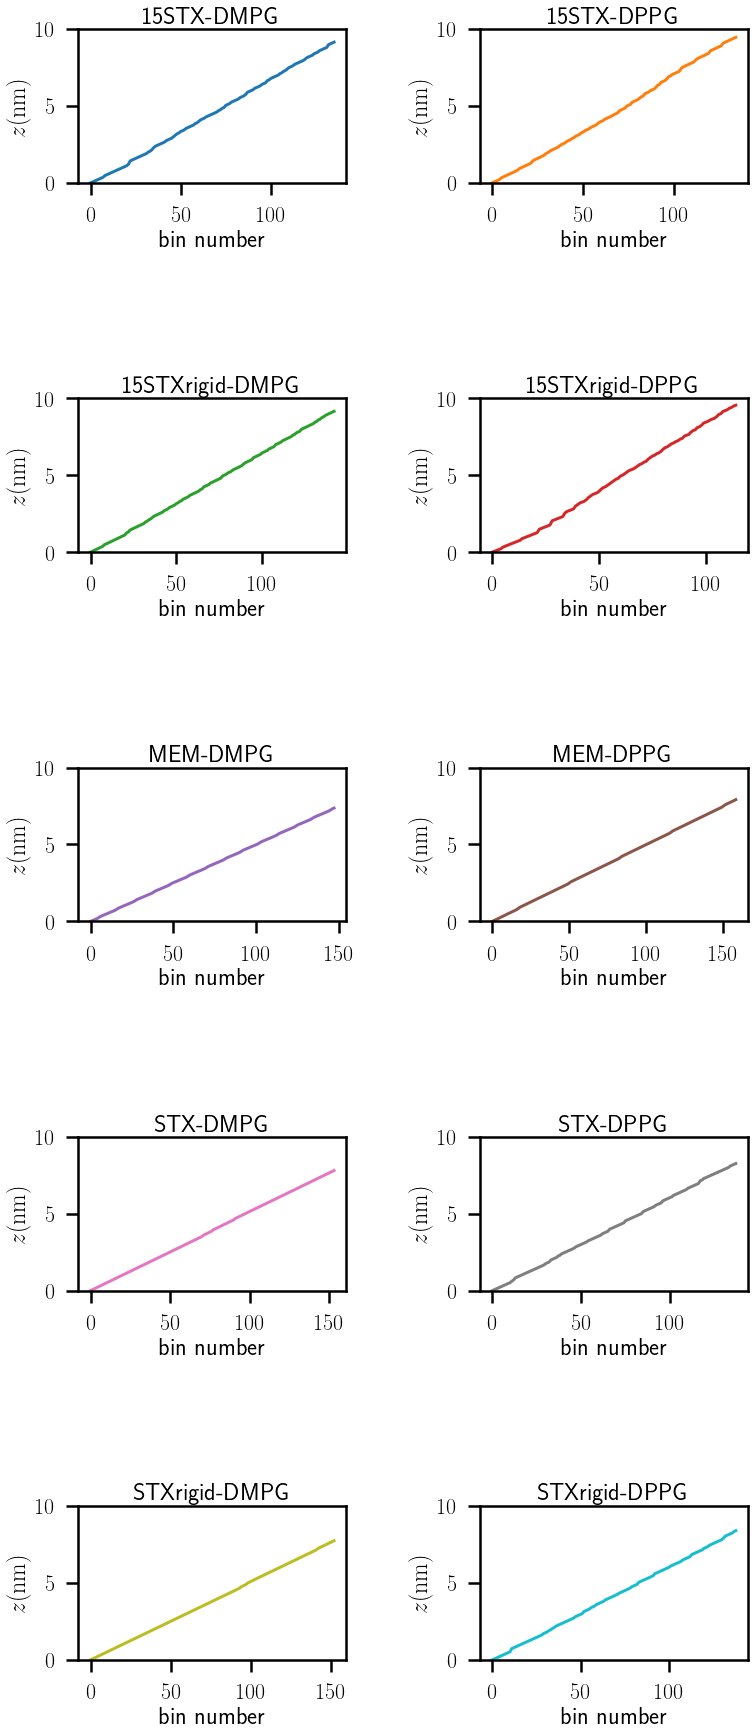

In [12]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=False,figsize=(12,30),gridspec_kw={'hspace': 1.4, 'wspace': 0.5})
for i in range(N):
    for j in range(M):
        z,stress=sort("mdstress/stress.txt",Sim_Direc[cnt],2,2,0.05)
            #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        ax[i][j].plot(np.arange(len(av(z))),av(z),color=col[cnt])
            #ax[k][j].set_yticklabels([-1010,-1000,-500,0,500,1000,1010])#np.arange(-1200,1200,200))#, fontsize=12)
        ax[i][j].set_xlabel(r"bin number $\displaystyle$")
        ax[i][j].set_ylabel(r"$\displaystyle z(\mathrm{nm}) $")
        ax[i][j].set_title("{}".format(Sim_Direc[cnt]))
        ax[i][j].set_ylim(0,10)
        cnt+=1
plt.savefig("../Plots/z_bin.png")

## Examples

(136, 5) 	 (136, 5, 10)


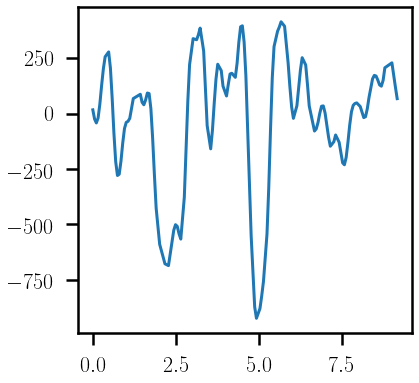

In [13]:
j=0
z,sigma=sort("mdstress/stress_2.txt",Sim_Direc[j],2,2,0.05)#stress,z=f("mdstress/stress.txt",Sim_Direc[4],2,2)
plt.figure(figsize=(6,6))
plt.plot(z[:,0],pi(sigma[:,:,:])[:,0])

In [14]:
pi_max=np.max(pi(sigma[:,:,:]))
print("Pi_max={}".format(pi_max))
pos=np.where(pi(sigma[:,:,:])==pi_max)
#print(b)
#print(pi(sigma[:,:,:])[b[0][0],b[1][0]])
print("z_0={}".format(z[pos[0][0],pos[1][0]]))
print(sigma[pos[0][0],pos[1][0],:])
print("Sigma={} ".format(-((sigma[pos[0][0],pos[1][0],0]+sigma[pos[0][0],pos[1][0],4])/2-sigma[pos[0][0],pos[1][0],8])))

Pi_max=755.1429915266266
z_0=4.277103659573599
[-143.21948439  -55.41502066  162.71660487  -55.41502066 -206.06339538
   73.46712155  162.71660487   73.46712155  580.50155165    0.        ]
Sigma=755.1429915266266 


In [15]:
#por replica
for i in range(5):#74):
    print(i,"\t",sigma[0,i,:],"\t",z[0,i]) #stress size

0 	 [  79.75372228 -265.10964879  102.96017948 -265.10964879  222.64611178
   37.14948605  102.96017948   37.14948605  168.35622392    0.        ] 	 0.0
1 	 [ 164.23471901 -192.14264517   90.82570001 -192.14264517  -17.40720472
  209.86514566   90.82570001  209.86514566  125.87223248    0.        ] 	 0.0
2 	 [194.71510281  28.33678535 -78.88864442  28.33678535  60.58912978
 -11.32515348 -78.88864442 -11.32515348  -5.56822124   0.        ] 	 0.0
3 	 [ 348.63732576  251.47863702 -118.48092804  251.47863702   60.42089125
 -121.7382246  -118.48092804 -121.7382246   178.94117306    0.        ] 	 0.0
4 	 [ -81.22441563   85.10159795 -192.1941157    85.10159795    7.74050853
   46.64364839 -192.1941157    46.64364839 -137.91419865    0.        ] 	 0.0


# Stress profiles averaged for all replicas (neither filter nor symetrization)

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


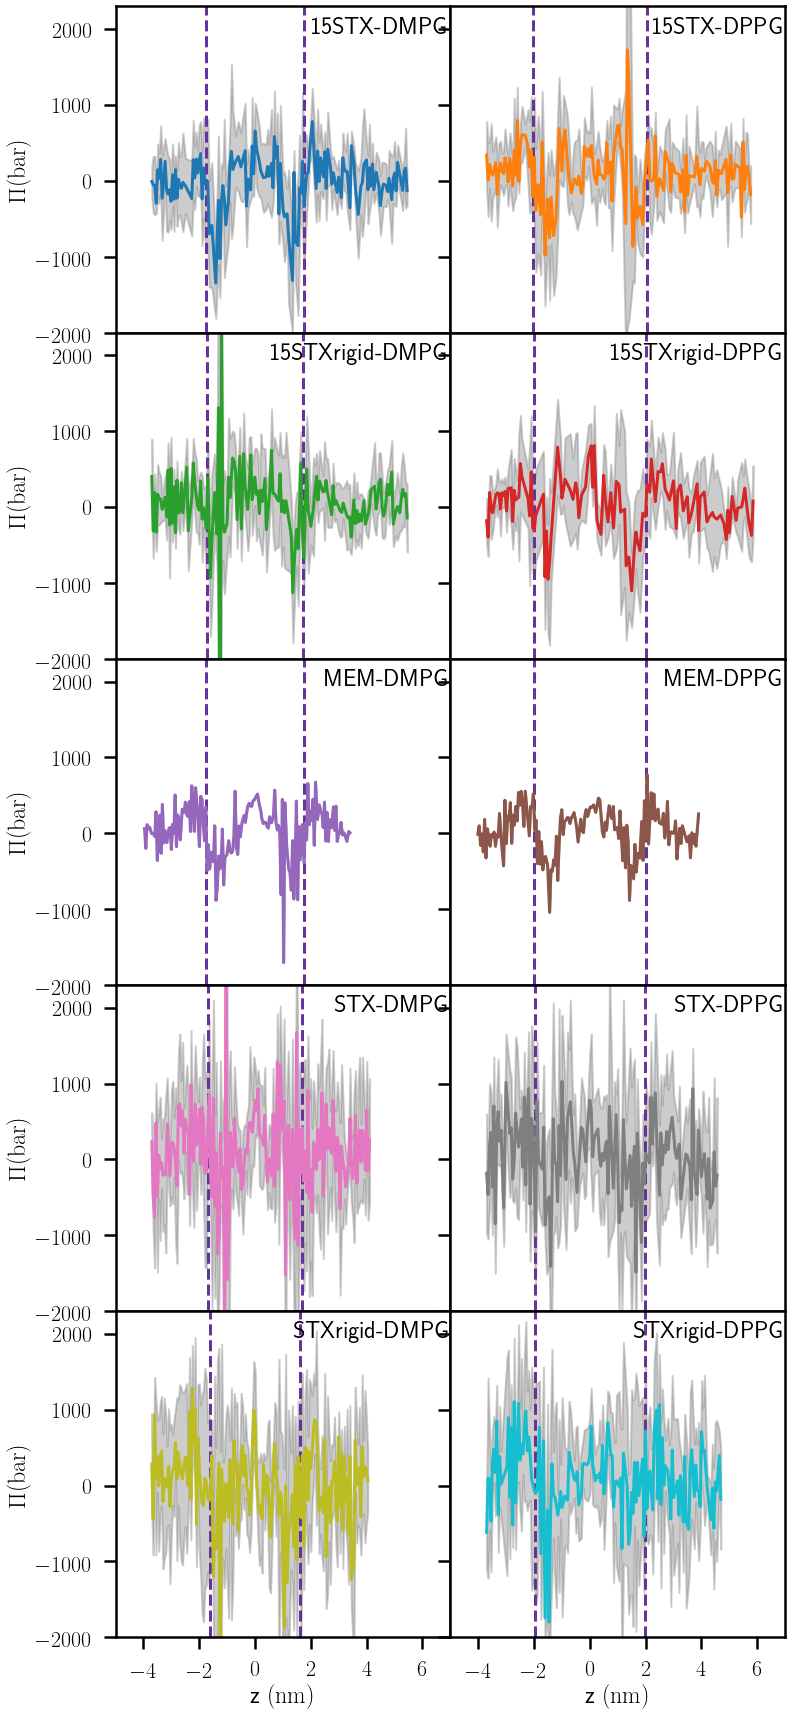

In [16]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=True,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(N):
    for j in range(M):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7
#         if(not "MEM" in Sim_Direc[cnt]):
        z,stress=sort("mdstress/stress.txt",Sim_Direc[cnt],2,2,0.05)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')
                #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        ax[i][j].plot(av(z-z_com),av(pi(stress)),color=col[cnt]) #,xerr=e_z,yerr=e_pi
        ax[i][j].fill_between(av(z-z_com), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:
            
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        ax[i][j].set_ylim(-2000.,2300)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
        cnt+=1
    #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
plt.savefig("../Plots/stress_profile.png")

## Stress profile applying gaussian filtering of 2 sd

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


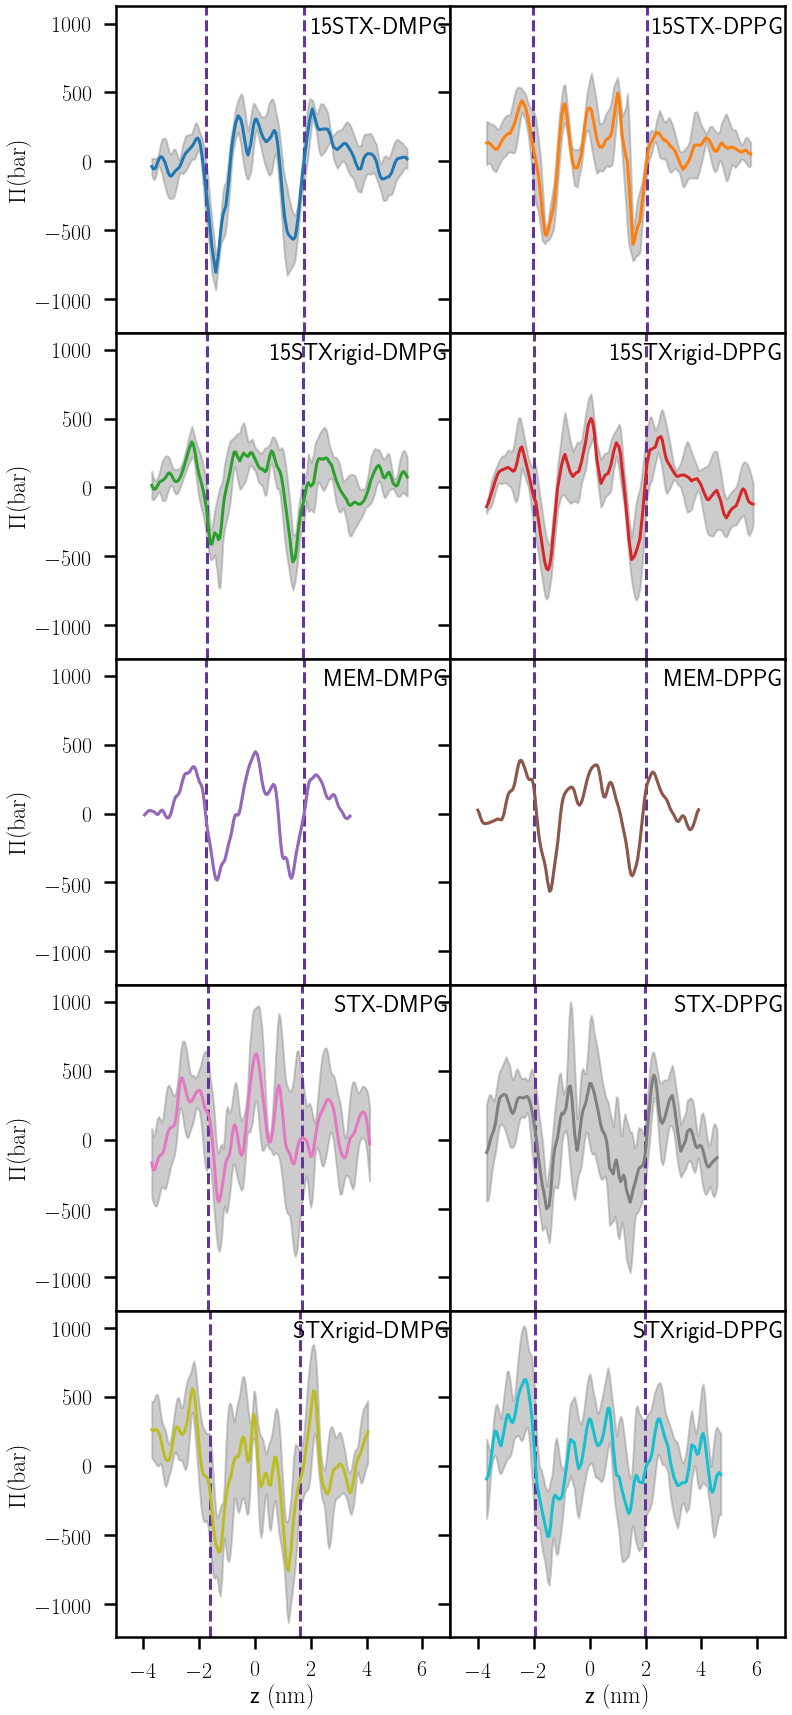

In [17]:
cnt=0
N=5
M=2
fig,ax  = plt.subplots(N,M,sharex=True,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0, 'wspace': 0})
for i in range(N):
    for j in range(M):
        if("MEM" in Sim_Direc[cnt]):
            start=1;
            N=1
            if("DMPG" in Sim_Direc[cnt]):
                z_com=3.96152
            elif("DPPG" in Sim_Direc[cnt]):
                z_com=4.01457
        else:
            start=1;
            N=5
            z_com=3.7

#         if(not "MEM" in Sim_Direc[cnt]):
        z,stress=sort("mdstress/stress_2.txt",Sim_Direc[cnt],2,2,0.05)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')
        #ax[k][j].scatter(z,-stress[:,4],color=col[cnt])
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        ax[i][j].plot(av(z-z_com),av(pi(stress)),color=col[cnt]) #,xerr=e_z,yerr=e_pi
        ax[i][j].fill_between(av(z-z_com), av(pi(stress))-e_pi, av(pi(stress))+e_pi,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
#         else:
            
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
#         if(cnt<2):
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        #ax[i][j].set_ylim(-2000.,2000)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
        cnt+=1

    #plt.savefig("../Plots/{}_stress_profile.png".format(Sim_Direc[i]))
plt.savefig("../Plots/stress_profile_2.png")

# Simmetrization and manual filtering

In [18]:
def z_com(direc):
    if("MEM" in direc):
        if("DMPG" in direc):
            z=3.96152
        elif("DPPG" in direc):
            z=4.01457
    else:
        z=3.7
    return z

In [19]:
def sym(z,stress,z_COM,sk_l1):#file,direc,replica,z_com,sk_l1):
#         work_dir = "{}/{}/{}".format(bas_dir[0],direc,replica)
#         data = np.genfromtxt("{}/{}".format(work_dir,file),skip_header=sk_l1)
#         z=data[:,0]
#         stress=data[:,1:]
        z_inf=[]
        stress_inf=[]
        stress_inf2=[]
        z_sup=[]
        z_inf2=[]
        z_f=[]
        s_f=[]
        z_f2=[]
        s_f2=[]
        stress_sup=[]
        z-=z_COM
        for i in range(len(z)):
            if(z[i]<0):
                z_inf.append(z[i])
                stress_inf.append(stress[i])
            else:
                z_sup.append(z[i])
                stress_sup.append(stress[i])
        for i in range(len(z_inf)):
            z_inf2.append(z_inf[len(z_inf)-1-i])
            stress_inf2.append(stress_inf[len(z_inf)-1-i])
        if(len(z_inf)<len(z_sup)):
            m=len(z_inf)
            M=len(z_sup)
            for i in range(int(m+(M-m)/2)):#len(z_inf)+(len(z_sup)-len(z_inf))/2
                if(i<m):
                    s_f.append((stress_inf2[i]+stress_sup[i])/2)
                    z_f.append((-z_inf2[i]+z_sup[i])/2)
                else:
                    z_f.append(z_sup[i])
                    s_f.append(stress_sup[i])
        else:
            m=len(z_sup)
            M=len(z_inf)
            for i in range(int(m+(M-m)/2)):#len(z_sup)+(len(z_inf)-len(z_sup))/2
                if(i<m):
#                    print("a")#stress_inf[i,:])
                    s_f.append((stress_inf2[i]+stress_sup[i])/2)
                    z_f.append((-z_inf2[i]+z_sup[i])/2)
                else:
                    z_f.append(-z_inf2[i])
                    s_f.append(stress_inf2[i])
        for i in range(len(z_f)):
            z_f2=np.append(z_f2,-z_f[len(z_f)-1-i])
            s_f2=np.append(s_f2,s_f[len(z_f)-1-i])
#         print(np.shape(s_f[len(z_f)-1-i][:]))
        z_f2=np.append(z_f2,z_f)
        s_f2=np.append(s_f2,s_f)
        #print(np.shape(z_f2),np.shape(s_f2))
        return z_f2,s_f2#.reshape(int(len(s_f2)/9),9)

In [20]:
titles="z	Sxx	Sxy	Sxz	Syx	Syy	Syz	Szx	Szy	Szz"
#titles=["z","Sxx","Sxy","Sxz","Syx","Syy","Syz","Szx","Szy","Szz"]

(136, 5) 	 (136, 5, 10)
(135, 5) 	 (135, 5, 10)
(143, 5) 	 (143, 5, 10)
(115, 5) 	 (115, 5, 10)
(148, 1) 	 (148, 1, 10)
(159, 1) 	 (159, 1, 10)
(154, 5) 	 (154, 5, 10)
(138, 5) 	 (138, 5, 10)
(153, 5) 	 (153, 5, 10)
(139, 5) 	 (139, 5, 10)


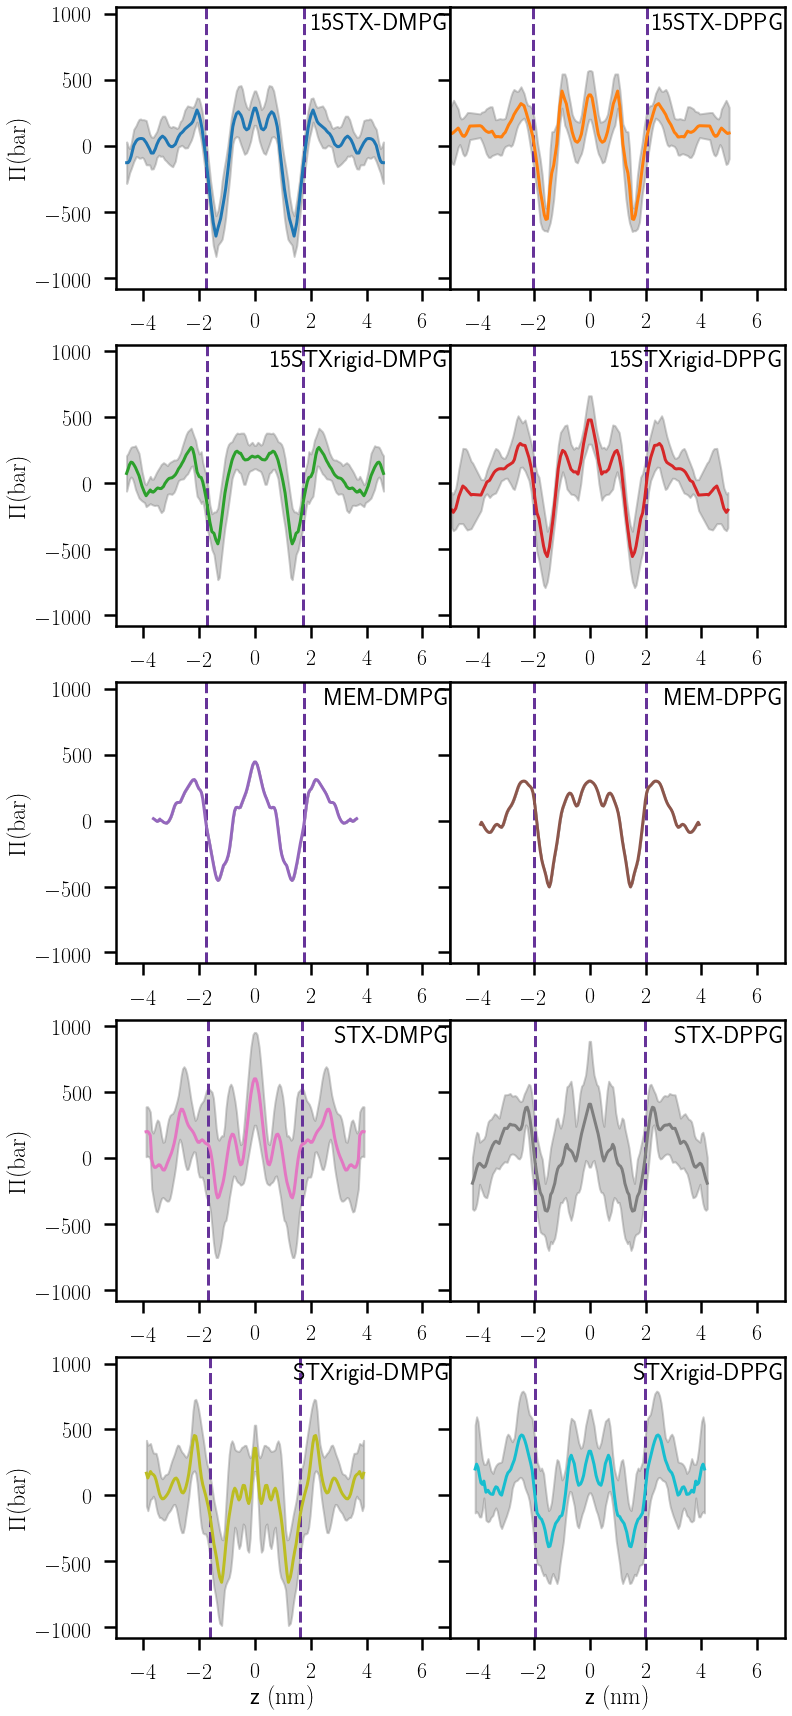

In [21]:
cnt=0
N1=5
M=2
fig,ax  = plt.subplots(N1,M,sharex=False,sharey=True,figsize=(12,30),gridspec_kw={'hspace': 0.2, 'wspace': 0})
for i in range(N1):
    for j in range(M):
        work_dir = ("{}/{}".format(Sim_Direc[cnt],1))
        z,stress=sort("mdstress/stress_2.txt",Sim_Direc[cnt],2,2,0.05)
        #z_p,p_dens=sort("density/p_density.xvg",Sim_Direc[cnt],0,0,0.15)
        p1,p2=phosphate("density/p_density.xvg",Sim_Direc[cnt],0)
        ax[i][j].axvline(p1,linestyle="--",color='rebeccapurple')
        ax[i][j].axvline(p2,linestyle="--",color='rebeccapurple')
#         print(np.shape(z_d),np.shape(av(np.array(sigma_d))))
        #print(z_com(Sim_Direc[cnt]),np.shape(av(pi(stress))))
        z_sym,pressure_sym=sym(av(z),av(pi(stress)),z_com(Sim_Direc[cnt]),2)
        e_z=[]
        e_pi=[]
        for k in range(len(z[:,0])):
            e_z.append(2*np.std(z[k,:])/np.sqrt(N))
            e_pi.append(2*np.std(pi(stress)[k,:])/np.sqrt(N))
        z_sym,e_z_sym=sym(av(z),e_z,z_com(Sim_Direc[cnt]),2)
        z_sym,e_pi_sym=sym(av(z),e_pi,z_com(Sim_Direc[cnt]),2)
        #print(np.shape(z_sym),np.shape(pressure_sym))
        ax[i][j].plot(z_sym,pressure_sym,color=col[cnt])
        ax[i][j].fill_between(z_sym, pressure_sym-e_pi_sym, pressure_sym+e_pi_sym,color="gray",alpha=0.4)
        if(cnt%2==0):
            ax[i][j].set_ylabel(r"$\displaystyle \Pi \mathrm{ (bar)} $")
        if(cnt>7):
            ax[i][j].set_xlabel(r"z $\displaystyle (\mathrm{nm})$")
        ax[i][j].set_title("{}".format(Sim_Direc[cnt][:]),x=1./1.,y=.9/1.,loc="right")
        ax[i][j].set_xlim(-5,7.,100)
        #ax[i][j].set_ylim(-2000.,2000)
        ax[i][j].set_xticks(np.arange(-4.,7.,2.))
############
        cnt+=1
plt.savefig("../Plots/stress_profile_2_sym.png")